<a href="https://colab.research.google.com/github/yangyangkiki/LTU-CSE5CV-Term5-Labs/blob/main/Lab_02_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE5CV - Face Detection
In this lab we explore two different approaches to face detection.

By the end of this lab, you should be able to:
* Understand and implement Haar Cascades using *OpenCV*
* Implement basic Deep Neural Networks with *OpenCV*

## Colab preparation

Google Colab is a free online service for editing and running code in notebooks like this one. To get started, follow the steps below:

1. Click the "Copy to Drive" button at the top of the page. This will open a new tab with the title "Copy of...". This is a copy of the lab notebook which is saved in your personal Google Drive. **Continue working in that copy, otherwise you will not be able to save your work**. You may close the original Colab page (the one which displays the "Copy to Drive" button).
2. Run the code cell below to prepare the Colab coding environment by downloading sample files. Note that if you close this notebook and come back to work on it again later, you will need to run this cell again.

In [ ]:
!git clone https://github.com/ltu-cse5cv/cse5cv-labs.git
%cd cse5cv-labs/Lab05

## Packages
In this lab we will be using the following packages:
* *OpenCV* for face detection
* *numpy* for interacting with image data
* *skimage* for manual Haar cascades
* *sklearn* for computing accuracy
* *matplotlib* for visualization

In [ ]:
import math

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.data import lfw_subset
from skimage.feature import draw_haar_like_feature, haar_like_feature_coord, haar_like_feature
from skimage.transform import integral_image
from sklearn.metrics import accuracy_score
from urllib.request import urlopen

In this lab, we will create many functions to perform parts of face detection and recognition. For your reference when answering later questions, here is a list of all of those functions.

**General Functions**
* *`display_image()`*
* *`load_image_from_url()`*
* *`draw_rectangles_tlbr()`*

**Manual Haar Cascades**
* *`classify_manual_haar_features()`*
* *`extract_custom_haar_features()`*

**Haar Cascades**
* *`preprocess_image_haar()`*
* *`detect_faces_haar()`*
* *`haar_detect_and_overlay_from_url()`*

**DNN Face Detection**
* *`preprocess_image_dnn()`*
* *`postprocess_detections_dnn()`*
* *`detect_faces_dnn()`*
* *`dnn_detect_and_overlay_from_url()`*

# 1. Haar Cascades

A Haar cascade classifier is a machine learning based approach to object detection proposed in the 'Robust Real-Time Face Detection' paper.  


To implement Haar cascades for object detection, a large number of features are efficiently extracted from an image and fed through a feature selector algorithm which selects the most important features and trains a series of classifiers to be able to efficiently detect the presence of an object. This training is faciliated through a dataset containing positive and negative examples of what is to be detected.  

In this section we will describe the process in more detail and implement a subset of the functionality of Haar cascades.

## 1.1 Haar Features

The first step of Haar cascades is to extract the Haar features from an image.

In the original paper, the authors introduced three different kinds of features to extract from an image. These features involve grouped rectangles of identical size and shape that are moved around a detection window, where the pixel values in one part of the rectangle are subtracted from pixel values in the other part of the rectangle.

In the below code cell we display the different types of features described in the paper.

In [ ]:
# Create images for visualization
images = [np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((2, 2))]

# Describe each type of feature to be extracted
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']

# Go through each feature and draw on the image
fig, axs = plt.subplots(1, 5, figsize=(19.2, 10.8))
axs = np.ravel(axs)
for ax, img, feat_t in zip(axs, images, feature_types):
    coord, _ = haar_like_feature_coord(img.shape[1], img.shape[0], feat_t)
    haar_feature = draw_haar_like_feature(img, 0, 0, img.shape[1], img.shape[0],
                                          coord, max_n_features=1, random_state=0)
    ax.imshow(haar_feature)
    ax.set_title(feat_t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.axis('off')
plt.show()

With reference to the displayed data above, the Haar features are described as the sum of pixel values in the green sections subtracted from the sum of pixel values in the red sections.

The three features described in the paper are:
* A two-rectangle feature (These can be seen in the first two visualizations)
* A three-rectangle feature (Seen in the third and fourth visualizations)
* A four-rectangle feature (Seen in the last visualization)

When finding the Haar features, these rectangular windows are moved and resized within a detection window, and at each position the difference of sums is taken. This detection window is usually smaller than the whole image, so for detecting objects within a whole image, the detection window is moved around the image, and within each position of the detection window Haar features are computed.

In the code cell below we create an empty 4x4 pixel detection window and show the position of the four-rectangle feature as it is moved and resized throughout the window.

In [ ]:
# Create an empty 4x4 pixel image
original_image = np.zeros((4, 4))

# Compute coordinate of the four-rectangle feature computed on this image
feature_coord, _ = haar_like_feature_coord(original_image.shape[1], original_image.shape[0], 'type-4')
print(f'There are {feature_coord.shape[0]} positions of this feature in the '
      f'{original_image.shape[0]}x{original_image.shape[1]} image')

# Determine the number of plots required for a square axis
square_axis = math.ceil(feature_coord.shape[0] ** 0.5)
fig, axs = plt.subplots(square_axis, square_axis, figsize=(19.2, 10.8))
axs = np.ravel(axs)

# Plot positions of each feature individually
for idx in range(feature_coord.shape[0]):
    feat_coord = feature_coord[idx:idx+1]
    image = draw_haar_like_feature(original_image, 0, 0, original_image.shape[1], original_image.shape[0],
                                   feat_coord, max_n_features=1, random_state=0)
    axs[idx].imshow(image)

plt.show()

You can imagine as the detection window grows, so too does the number of features extracted!

## 1.2 Integral Image

Computing these features can become very computationally expensive (summing values in each rectangle and subtracting from one another). As seen in the previous section, an enormous number of features are extracted for larger detection windows, which quickly becomes infeasible to compute.

Because of this, the authors introduced a different representation of an image to address this. This representation is called an ***integral image***.

We wont go into detail on how this helps compute Haar features, however we will look at what an integral image looks like.

In a nutshell, an **integral image** is one where each pixel represents the sum of that pixel value, plus all pixel values above and to the left of it in the original image.

This is best illustrated with an example. The code cell below creates a 5x5 array of ones, then computes the integral image using *numpy*.

In [ ]:
sample_image = np.ones((5, 5))
print(sample_image)

print('-' * 20)

integral_sample_image_numpy = np.cumsum(np.cumsum(sample_image, axis=0), axis=1)
print(integral_sample_image_numpy)

We can also achieve this same result using a function available to us in *scikit-image*.

**Task**: Find the appropriate function in the [*scikit-image.transform* documentation](https://scikit-image.org/docs/dev/api/skimage.transform.html) to compute the integral image. Use this function to compute and print the integral image of `sample_image`. Verify that it matches the result with the given *numpy* implementation.

In [ ]:
# TODO: Your solution here


# TODO: Verify your result matches the numpy implementation
print(integral_sample_image_numpy)

In [ ]:
#@title Task solution

# TODO: Your solution here
# NOTE: We have already imported the integral_image function
integral_sample_image_scipy = integral_image(sample_image)
print(integral_sample_image_scipy)

# TODO: Verify your result matches the numpy implementation
print(integral_sample_image_numpy)

**Comprehension Question**

Determine the integral image for the array shown below ***by hand***.

$$
\begin{equation*}
\begin{bmatrix}
0 & 1 & 2 & 3 \\
4 & 5 & 6 & 7 \\
8 & 9 & 10 & 11 \\
12 & 13 & 14 & 15 \\
\end{bmatrix}
\end{equation*}
$$

Run the code cell below to check your answer

In [ ]:
arr = np.arange(16).reshape(4, 4)
print(arr)

print('-' * 20)

integral_arr = integral_image(arr)
# Or
# integral_arr = np.cumsum(np.cumsum(arr, axis=0), axis=1)

print(integral_arr)

How can we use the integral image to help us compute Haar features?

In the Haar features section we discussed that to compute a Haar feature we place a set of rectangles over a detection window and compute the feature as the sum of pixel values in the different coloured sections subtracted from eachother. In our examples, we have defined this as the sum of pixel values in the green sections subtracted from the sum of pixel values in the red sections.

To illustrate this with an example, consider an 8x8 array filled with ones, where we want to compute the four-rectangle feature that spans the whole array. The integral image for this is shown below (values in the array are in the bottom-right corner of each cell in the array), with the four-rectangle feature visualization overlaid:

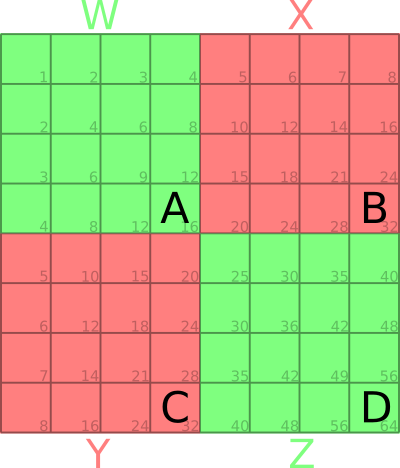

To compute the Haar feature, we need to find the sum of values in the green sections (`W` and `Z`) of the original array and subtract this from the sum of values in the red sections (`X` and `Y`) of the original array.

Because we have the integral image, this becomes very easy to do!

Consider section `W`. The sum of pixel values in this section of the original array would be 16 (a 4x4 array of ones), however in the integral image, this is equivalent to the value in the cell depicted by `A`.

Considering section `X` we find something similar. The cell depicted by `B` contains the sum of pixel values in the original array of sections `W` and `X`. To find the sum of values in `X` alone, we just need to subtract the sum of pixel values in `W` (which is represented by the value in cell `A`) from `B`!

Following this logic, you can determine how the sum of values in sections `Y` and `Z` are found. As you can see, it becomes extremely simple to find these values by just looking them up in the integral image, rather than summing across subarrays in the original array.

**Task**: In the code cell below we provide code representing the example we just described. Complete the line that computes the Haar feature.

In [ ]:
# Create a sample image and compute the integral image
sample_image = np.ones((8, 8))
int_img = np.cumsum(np.cumsum(sample_image, axis=0), axis=1)

# Extract the values of cells A, B, C, D
A = int_img[3, 3]
B = int_img[7, 3]
C = int_img[3, 7]
D = int_img[7, 7]

# Find the sum of values in the original image in the sections W, X, Y, Z
W = A
X = B - A
Y = C - A
Z = D - C - B + A

# TODO: Compute the Haar feature
# haar_2x2_feature = ...

print(haar_2x2_feature)    # Should be 0.0

In [ ]:
#@title Task solution

haar_2x2_feature = W - X - Y + Z

## 1.3 Using Features for Classification

The next step in using Haar cascades for object detection would be to efficiently select a subset of features from the feature set to use, and create classifiers to detect objects given a training set. The code to implement this is quite complex, and outside of the scope of this lab.

Instead, we will take what we've covered so far and implement our own (*poor*) classifier, based on a subset of (*poorly chosen*) features.

### Dataset

For this task, we will be making use of a subset of data from the [Labelled Faces in the Wild dataset](http://vis-www.cs.umass.edu/lfw/).

Specifically, the [subset we will be using](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.lfw_subset) contains 200 images, 100 faces and 100 non-faces. All of these images have been resized to 25x25px.

In the code cell below we download this dataset and print some properties of the data.

In [ ]:
lfw_subset_dataset = lfw_subset()
print(f'Shape of data: {lfw_subset_dataset.shape}')
print(f'Type of data: {lfw_subset_dataset.dtype}')
print(f'Pixel value range of data: {lfw_subset_dataset[0].min(), lfw_subset_dataset[0].max()}')

To better understand this dataset, we should visualize a few examples, meaning we need some visualization code!

**Task**: In the code cell below, write a function `display_image` that takes an *image* and optionally a *title*, and displays the image (with the title if provided). Ensure this works for both RGB and greyscale images. Set the *figsize* of your plot to be: `(8, 6)`

<details>
<summary style='cursor:pointer;'><u>Hint</u></summary>

You've written code similar to this in Lab 1 and Lab 3. Refer back to those labs to see the display functions you wrote. This display function will require parts from functions in each of those labs.
</details>

In [ ]:
# TODO: Your function here




# Test your function! We multiply the image data by 255 to get it in the range [0, 255] for displaying
display_image(lfw_subset_dataset[0] * 255, 'Face')
display_image(lfw_subset_dataset[100] * 255, 'Not a Face')

In [ ]:
#@title Task solution

def display_image(image, title=None):
    fig, axes = plt.subplots(figsize=(8, 6))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    if title is not None:
        plt.title(title)

    plt.show()

Following that, you will have seen an example of a face and an example of a non-face being displayed. In this dataset the first 100 examples are faces, and the last 100 examples are non-faces.

### Classification

Now we have a dataset, let's move on to classification on this dataset!  

The typical approach for detection with Haar cascades is to:
1. Compute a set of features within a detection window
2. Select a subset of these features to use and perform binary classification based on those features
3. Repeat steps 1. and 2. for all positions of the detection window within the image (the detection window is convolved across the image)

This is a complex process, so to keep things simple for our implementation, we will just focus on steps 1. and 2. Also, we will set the detection window to the same size as our images, meaning we produce a single classification for the whole image.

Choosing features is a very important process to create a good Haar classifier, and the Haar cascade implementation uses an algorithm named **Adaboost** to do this. For our purposes, we are going to select a subset of features in a very crude way **Note: You should never do feature selection in this way in practice**.

In the code cell below, we (*crudely*) select 5 Haar features that we will use for classification.

In [ ]:
# Compute coordinates of Haar features within a detection window of size 25x25 for four-rectangle features
# We choose 25x25 to match our dataset image sizes
feature_coords, feature_types = haar_like_feature_coord(25, 25, 'type-4')

# Extract the first 5 features. We will use these for classification
feature_coords = feature_coords[:5]
feature_types = feature_types[:5]

Next up, we need to determine what to do with these 5 features to classify the image as a *face* or *non-face*. To do this, your tutor has found a decision boundary that works reasonably well.

In the code cell below, we define a function `classify_manual_haar_features()` which takes the set of computed features and returns the classification label: `Face` or `Not a Face`.

In [ ]:
def classify_manual_haar_features(features):
    if abs(sum(features)) > 0.1:
        return 'Face'
    else:
        return 'Not a Face'

Now that we have chosen a set of features to use and have specified a function that can take a set of features and perform classification, the remaining steps are to write some code to extract the features from an image and then perform classification on some images!

We will do this in 2 stages. First we will write a function to extract a set of features from an image, then we will write some code to bring everything together.

**Task**: Create a function `extract_custom_haar_features` that takes an *image*, *feature_coordinates* and *feature_types*. This function should extract the Haar features described by the features coordinates and feature types from the image. Look in the [*`skimage.feature`* documentation](https://scikit-image.org/docs/dev/api/skimage.feature.html) for a function that will let you compute Haar like features.

<details>
<summary style='cursor:pointer;'><u>Hint</u></summary>

Specifically, you should use the *`haar_like_feature()`* function. You will need to first compute the integral image before using this function. The detection window is equal to the image size.
</details>

In [ ]:
# TODO: Your function here



# TODO: Test your function (See if your function produces the expected features for this input)
sample_image = np.ones((5, 5))
expected_features = [0, 0, 1, 3, 5]
extracted_features = extract_custom_haar_features(sample_image, feature_coords, feature_types)
print(expected_features == extracted_features)   # Validate that all of these are 'True'

In [ ]:
#@title Task solution

def extract_custom_haar_features(image, feature_coords, feature_types):
    integral_img = integral_image(image)
    features = haar_like_feature(integral_img, 0, 0, integral_img.shape[1], integral_img.shape[0],
                                 feature_coord=feature_coords, feature_type=feature_types)
    return features

Great work! All that's left is to write some code to bring everything together and classify some images in our dataset.

**Task**: Write code to classify the first image in `lfw_subset_dataset` by extracting the Haar features described by `feature_coords` and `feature_types`, then display the image along with the classification label as the title. Repeat this for the image at index 100 in `lfw_subset_dataset`.

In [ ]:
# TODO: Extract the first image in lfw_subset_dataset



# TODO: Extract the features of the image



# TODO: Classify the image, storing the classification label



# TODO: Display the image along with the classification label (Remember, you'll need to multiply the image data by 255)



# TODO: Repeat the above steps for the image at index 100




How did it go? If everything was implemented correctly, you should have seen our (poor) classifier based on a subset of (poorly chosen) features actually did pretty well!

In [ ]:
#@title Task solution

# TODO: Extract the first image in lfw_subset_dataset
image = lfw_subset_dataset[0]


# TODO: Extract the features of the image
features = extract_custom_haar_features(image, feature_coords, feature_types)


# TODO: Classify the image, storing the classification label
label = classify_manual_haar_features(features)


# TODO: Display the image along with the classification label (Remember, you'll need to multiply the image data by 255)
display_image(image * 255, label)


# TODO: Repeat the above steps for the image at index 100
image = lfw_subset_dataset[100]
features = extract_custom_haar_features(image, feature_coords, feature_types)
label = classify_manual_haar_features(features)
display_image(image * 255, label)

### Evaluation

Whilst we achieved perfect classification results on two images, it's important that we perform this evaluation on a larger dataset to see if our features only work well on these two images, or if they generalize well to other images.

#### Task

**Task**: Write some code below that loops through all images in `lfw_subset_dataset` classifies them using the Haar features described by `feature_coords` and `feature_types` then appends the classification label for each image to the list of `predictions`.

In [ ]:
predictions = []

# TODO: Loop through the image dataset and append each classification label to the predictions list



# Use this to validate that your list of predictions is populated
print(predictions)

In [ ]:
#@title Task solution

predictions = []

# TODO: Loop through the image dataset and append each classification label to the predictions list
for image in lfw_subset_dataset:
    features = extract_custom_haar_features(image, feature_coords, feature_types)
    label = classify_manual_haar_features(features)
    predictions.append(label)

# Use this to validate that your list of predictions is populated
print(predictions)

#### Calculating accuracy

With a quick glimpse of the printed `predictions`, we can see that our classifier seemed worked reasonably well, but it did misclassify a few examples (The first 100 examples are faces, the last 100 are non-faces).

Let's quantify this by computing the accuracy score of this dataset!

Using the list of `predictions` you computed in the previous code cell and the given list of `ground_truth` labels, the code below will compute and print out the accuracy score.

In [ ]:
ground_truth = ['Face'] * 100 + ['Not a Face'] * 100

# TODO: Compute and print the accuracy score given the predictions and ground_truth labels
dataset_accuracy = accuracy_score(y_true=ground_truth, y_pred=predictions)
print(f'Accuracy: {dataset_accuracy * 100:.2f}%')

#### Displaying all results

You should have seen an accuracy score of 84.50%. This is a pretty good result given we are only computing 5 (*poorly chosen*) features, and using a very basic classifier. We would expect to do far better if we performed more-informed feature selection and a more advanced classifier.

For your interest, we provide code below to display the image and classification score for every image in the dataset. You are not required to run this code cell, but you may be interested in seeing which images the classifier misclassified. This output of this will consume a lot of vertical space on your screen.

In [ ]:
for image, ground_truth_label in zip(lfw_subset_dataset, ground_truth):
    features = extract_custom_haar_features(image, feature_coords, feature_types)
    label = classify_manual_haar_features(features)
    title = f'Prediction: {label}. Ground Truth: {ground_truth_label}. Correct: {label == ground_truth_label}'
    display_image(image * 255, title)

## 1.4 Further Reading

This section provides a very brief discussion of other components involved with Haar cascades.

### Normalization

We've seen in previous labs that before performing classification on image data there are usually some data preprocessing steps involved.

For Haar cascades in particular, data normalization was found to be a very important preprocessing technique. Normalizing data before classification helps to minimize the effect of different lighting conditions amongst images.

### Feature Selection

In our example, we chose 5 features to extract to perform classification. In practice, there are thousands of features you could extract, so how do we choose which ones to use?

For Haar cascades, an algorithm based on **Adaboost** is used. This is able to efficiently choose features by training a series of classifiers (given a labelled dataset) that end up only using features that are found to be important in the labelled dataset.

### Cascading

For even greater efficiency in processing, Haar cascades are arranged into a 'cascade of classifiers'. What this means is when features are being extracted from a detection window, at first a few features are extracted and classified. If the classification suggests the object being detected isn't there, then the detection window continues to move across the image, however if the classification suggests an object is present, then a further set of features are extracted and classified. This process is repeated over a certain number of cascades until a final classification is made.

The benefit of this approach is greatly saves on the processing time required. Consider the case of face detection. In a given image, faces generally make up less of the image than other background objects, hence it's expected that a large number detection windows should be considered as non faces. Being able to exclude these detection windows without extracting the complete set of features greatly speeds up processing.

# 2. Haar Cascades - OpenCV

Now we know the basics of Haar cascades and have attempted to implement them ourselves, let's move on to using an existing Haar cascades implementation that has been properly trained to detect specific objects in images (in this case face detection).

To do this, we will be using *OpenCV*.

## 2.1 Loading Sample Data

Let's first start by loading a sample image that contains multiple faces so we can evaluate how well Haar cascades can detect the faces.

**Task**: Given the following URL, load the image data into a *numpy* array and display it. We have provided the *`load_image_from_url()`* to help with this.

In [ ]:
url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'

def load_image_from_url(url):
    """Given a URL, loads the image into a numpy

    Image loaded in RGB, with HWC channel ordering

    Args:
        url (str): The URL of the image to load

    Returns:
        (np.ndarray): The RGB, HWC ordered image
    """
    with urlopen(url) as ur:
        image = np.asarray(bytearray(ur.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# TODO: Load the image from the given URL



# TODO: Display the image




In [ ]:
#@title Task solution

url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'


# TODO: Load the image from the given URL
image = load_image_from_url(url)


# TODO: Display the image
display_image(image)

## 2.2 Creating a Classifier

Next we will create our Haar cascade classifier.

We are going to be using a pre-trained Haar cascade classifier that has been specifically trained to detect faces in images.

The *OpenCV* implementation has a whole collection of different classifiers that have been trained. You can see a [list of classifiers](https://github.com/opencv/opencv/tree/master/data/haarcascades) available on their Github page. These pre-trained classifiers are stored in `.xml` files, where those files describe the filters used to detect faces within a detection window.

These `.xml` files are automatically downloaded when you install *OpenCV* to your machine.

**Task:** In the code cell below, create a Haar cascade classifier that we can use to detect faces. You will need to refer to the [CascadeClassifer documentation](https://docs.opencv.org/4.5.2/d1/de5/classcv_1_1CascadeClassifier.html#a6d01a748b103f0cd6bd2a20037ae8731) to see how it's done. Use the classifier described in the *haarcascade_frontalface_default.xml* file.

**NOTE**: To ensure we can find the path to the XML file, you should combine the XML filename with the path given to us by `cv2.data.haarcascades`

In [ ]:
# TODO: Setup the filepath to the XML classifier file
# xml_filepath = cv2.data.haarcascades +


# TODO: Create the Haar cascade classifier




In [ ]:
#@title Task solution

# TODO: Setup the filepath to the XML classifier file
xml_filepath = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'


# TODO: Create the Haar cascade classifier
haar_cascade_classifier = cv2.CascadeClassifier(xml_filepath)

## 2.3 Preprocessing

To perform classification with the Haar cascade classifier, we need to first apply some preprocessing to our image. In this case, we only need to convert our image to grayscale.

**Task**: Write a function `preprocess_image_haar` that takes an *image* as an argument (assumed to be in RGB), converts it to grayscale, then returns the grayscale image.

In [ ]:
# TODO: Your function here


# Use this to test your function (You should see a gray image)
gray_image = preprocess_image_haar(image)
display_image(gray_image)

In [ ]:
#@title Task solution

def preprocess_image_haar(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

## 2.4 Classification

Finally, let's perform classification and look at the results!

**Task**: In the code cell below, preprocess the above image, detect faces in the image using your `haar_cascade_classifier`, then print out the detection results. Store the detections in the variable: `detections_tlwh`. Refer to the documentation for a function you can use to detect objects in the image.

<details>
<summary style='cursor:pointer;'><u>Hint</u></summary>

Specifically, you should use the *`detectMultiScale()`* function.
</details>

In [ ]:
# TODO: Preprocess the above image



# TODO: Detect faces in the image using your Haar cascade classifier



# TODO: Print out the detections




<details>
<summary style='cursor:pointer;'><u>Expand for discussion</u></summary>

When looking at the documentation, you may have seen there were a number of arguments we can specify with the *`detectMultiScale()`* function. A brief description of the two most important ones are:
  
* `scaleFactor`: This specifies how much the image size is reduced by at each image scale. A larger scale factor means you are more likely to miss face detections, but the detector will run faster. A smaller scale factor means you are more likely to detect more faces, but at the expense of a slower detector.
* `minNeighbors`: This specifies for each detection how many neighbouring detections it should have to be retained. The idea here is that a reliably detected face will have many neighbours, whereas detections with few neighbours are likely to be false positives.
</details>



<details>
<summary style='cursor:pointer;'><u>What does the output represent?</u></summary>

As you've seen in the last lab, when performing object detection, we attempt to find the bounding box coordinates around objects in the image.
    
That means the output represents a list of detections in our image. The number of detections corresponds to the number of faces that were detected.
</details>

In [ ]:
#@title Task solution

# TODO: Preprocess the above image
gray_image = preprocess_image_haar(image)


# TODO: Detect faces in the image using your Haar cascade classifier
detections_tlwh = haar_cascade_classifier.detectMultiScale(gray_image)


# TODO: Print out the detections
print(detections_tlwh)

#### Comprehension Question

There are 4 numbers associated to each detection. By looking at these numbers, what does each one represent?


<details>
<summary style='cursor:pointer;'><u>Expand for discussion</u></summary>

The first two numbers represent the *top-left coordinates* of the rectangle bounding the detected object relative to the image. The third number represents the *width* of the bounding rectangle, and the fourth number represents the *height* of the bounding rectangle.
</details>

Given we have no ground truth detection annotations, it's very important for us to visualize how well the face detector worked. To do this, we can overlay the detected bounding rectangles over our original image and then display the overlaid image.

Bounding boxes are often represented in the [tlx, tly, brx, bry] form representing the top-left and bottom-right corners of the box. For consistency before visualizing these detections, we will transform them into the [tlx, tly, brx, bry] form.

In the code cell below we transform the coordinates to the [tlx, tly, brx, bry] form. If no detections are made, *`detectMultiScale()`* returns an empty tuple, hence we only transform the coordinates if a detection was made.

In [ ]:
# Transform coordinates from [tlx, tly, bw, bh] to [tlx, tly, brx, bry]
detections = detections_tlwh.copy()
if isinstance(detections, np.ndarray):
    detections[:, 2] = detections[:, 0] + detections[:, 2]
    detections[:, 3] = detections[:, 1] + detections[:, 3]

print(detections)

In the code cell below, we define a function that can take a list of bounding box detections (in tlx, tly, brx, bry form) and overlay them on an image.

In [ ]:
def draw_rectangles_tlbr(image, rectangles, colour=(255, 0, 0), thickness=1):
    """Draws a list of rectangles in [tlx, tly, brx, bry] form onto an image

    Args:
        image (np.ndarray): The image to overlay rectangles on
        rectangles (list of list/np.ndarray): A list of rectangles to overlay on the image.
            rectangles should be in the form: [tlx, tly, brx, bry].
        colour (3-tuple): The RGB colour to draw boxes in
        thickness (int): The thickness of the rectangles

    Returns:
        (np.ndarray): A copy of the image with all rectangles overlaid
    """
    # Copy the image to not mutate the original image
    image = image.copy()

    # Draw rectangles
    for rectangle in rectangles:
        tlx, tly, brx, bry = rectangle.astype(np.int32)
        cv2.rectangle(
            image, (tlx, tly), (brx, bry),
            color=colour, thickness=thickness)

    return image

**Task**: In the code cell below overlay the box detections onto the original image and display the overlaid image. You may want to change the default colour/thickness.

In [ ]:
# TODO: Overlay the detections onto the original image



# TODO: Display the image with detections overlaid




In [ ]:
#@title Task solution

# TODO: Overlay the detections onto the original image
overlaid_image = draw_rectangles_tlbr(image, detections, thickness=3)


# TODO: Display the image with detections overlaid
display_image(overlaid_image)

How did it perform?

If you left the default arguments to *`detectMultiScale()`*, then you'll likely see some false positives as part of all detected faces, and potentially even some faces detected twice.

In the discussion above, we saw that there were a couple of arguments we could specify to *`detectMultiScale()`* that impact the number of faces detected. We should perform some experimentation to see if we can find a good set of parameters that can maximize the faces detected, whilst minimizing false positives.  

To make this experimentation a bit easier, let's first write a function that can return face detections in an image, that allows us to configure the arguments to *`detectMultiScale()`*.

**Task**: Write a function named `detect_faces_haar` that takes an *image*, a *Haar cascade classifier* object, a *scale factor* and a number of *min neighbours*, and returns all detected faces in [tlx, tly, brx, bry] form. This function should perform any necessary preprocessing before performing detection.

In [ ]:
# TODO: Your solution here




In [ ]:
#@title Task solution

def detect_faces_haar(image, haar_cascade_classifier, scale_factor, min_neighbours):
    gray_image = preprocess_image_haar(image)
    detections = haar_cascade_classifier.detectMultiScale(gray_image, scaleFactor=scale_factor, minNeighbors=min_neighbours)
    if isinstance(detections, np.ndarray):
        detections[:, 2] = detections[:, 0] + detections[:, 2]
        detections[:, 3] = detections[:, 1] + detections[:, 3]
    return detections

**Task**: Use the function you wrote to attempt to find a set of *scale_factor* and *min_neighbours* parameters that have a good trade-off between maximizing faces detected whilst minimizing false positives.

These were the best results your tutor found without any false positives:

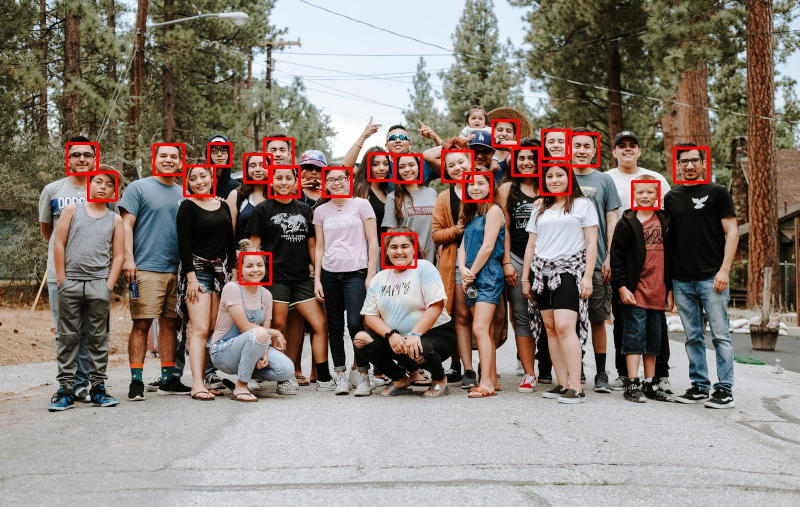

In [ ]:
# TODO: Detect faces within the image (specifying the scale_factor and min_neighbours arguments)



# TODO: Overlay the detections on your image



# TODO: Display the overlaid image



# TODO: Modify the scale_factor and min_neighbour parameters until you find a set of parameters with good trade-off

In [ ]:
#@title Task solution

# TODO: Detect faces within the image (specifying the scale_factor and min_neighbours arguments)
face_detections = detect_faces_haar(image, haar_cascade_classifier, 1.15, 6)

# TODO: Overlay the detections on your image
overlaid_image = draw_rectangles_tlbr(image, face_detections, thickness=3)

# TODO: Display the overlaid image
display_image(overlaid_image)

### Experimenting with more images

In the code cell below we provide a function that can load an image from a URL and overlay face detections. Feel free to test out how well this works on different images. Experiment with different *scale_factor* and *min_neighbours* parameters.

A good resource for finding sample images to classify is [Unsplash.com](https://unsplash.com/).  

To get the URL for an image from Unsplash:
1. Search for an image
2. Click on the desired image to open it up in a larger window
3. Right click on the image and select "copy image address"
4. Paste the copied URL into the code cell and run your code!

Can you find any examples where Haar cascades fail to detect faces? Can you explain why?  
Does this work well on images that do not contain any faces?

In [ ]:
def haar_detect_and_overlay_from_url(url, classifier, scale_factor, min_neighbours):
    url_image = load_image_from_url(url)
    detections = detect_faces_haar(url_image, classifier, scale_factor, min_neighbours)
    overlaid_image = draw_rectangles_tlbr(url_image, detections, thickness=3)
    display_image(overlaid_image)

# TODO: Insert your URL here
url = ''
haar_detect_and_overlay_from_url(url, haar_cascade_classifier, 1.3, 6)

## 2.5 Evaluation

Let's briefly look at an example where this Haar cascade falls apart.

**Task**: Given the below URL, detect and overlay any faces in the image using your Haar cascade classifier.

In [ ]:
url = 'https://images.unsplash.com/photo-1517841905240-472988babdf9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80'


# TODO: Load the URL, detect and overlay any faces




In [ ]:
#@title Task solution

url = 'https://images.unsplash.com/photo-1517841905240-472988babdf9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80'

# TODO: Load the URL, detect and overlay any faces
haar_detect_and_overlay_from_url(url, haar_cascade_classifier, 1.3, 6)

#### Comprehension questions

Your network didn't detect any faces at all!

**Comprehension Question 1**

Why didn't your Haar cascade classifier detect the face?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The pretrained Haar cascade classifier was only trained on frontal faces (Determined by the name of the `.xml` file: *haarcascade_frontalface_default.xml*). This means the features that your Haar cascade classifier uses are not tuned to detect faces that are turned to the side.
</details>

</br>

**Comprehension Question 2**

What can you do to get your Haar cascade classifier to detect this face?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

When training the Haar cascade classifier, you would need to include examples of faces that are turned to the side.
</details>

# 3. Deep Neural Networks - OpenCV

In this section we will look at using pre-trained deep learning object detection models specifically for face detection using *OpenCV*.

Since a background into deep learning object detection is provided in more detail elsewhere in the subject, we will instead focus here on the specifics of using the *OpenCV* implementation.

## 3.1 Loading Sample Data

Like for Haar cascades, let's first start by loading a sample image so we can evaluate how well we can detect faces.


In the code cell below we load and display the image data from the given URL.

In [ ]:
url = 'https://images.unsplash.com/photo-1517841905240-472988babdf9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=934&q=80'
image = load_image_from_url(url)
display_image(image)

## 3.2 Creating a Face Detection Model

We are going to use a pre-trained model for face detection. Specifically for this section, we are going to be using one that was originally trained with *Caffe*. For reference, *Caffe* is a deep learning framework, much like *PyTorch*.  

*OpenCV* can load networks trained in different frameworks. To load a network trained with *Caffe*, *OpenCV* needs two files:
* a `.txt` file describing the network architecture
* a `.caffemodel` file which contains the trained network weights

Along with this lab, you should have downloaded a `.txt` and `.caffemodel` file. In the code cell below we use these files to initialize our network.

In [ ]:
config_file = 'deploy.prototxt.txt'
model_file = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(config_file, model_file)

## 3.3 Preprocessing

Before using this model we need to apply preprocessing to our image data. This model expects images to be passed in with channel ordering BGR, and resized to 300x300 pixels.

The `preprocess_image_dnn` function defined below takes an `image` as an argument (assumed to be in RGB), converts it to BGR channel ordering, resizes to 300x300 pixels (ignoring aspect ratio), then returns the preprocessed image.

In [ ]:
def preprocess_image_dnn(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA)
    return image

preprocessed_image = preprocess_image_dnn(image)
display_image(preprocessed_image)

You may see that the image looks stretched. Typically we would want to address this by applying different preprocessing steps to our image data to get it to 300x300px, but we will leave it as-is for now. The colours will also look strange, since the channel ordering used by OpenCV (BGR) does not match the channel ordering used by matplotlib when displaying images (RGB).

## 3.4 Classification

The last step is to use our face detection model to detect faces in our image, then overlay the results to visually inspect how well it performed.

When we used *PyTorch* to make predictions on image data, we saw that we needed to first transpose the image data and then put it into a batch.

For *OpenCV*, we need to do something quite similar, however *OpenCV* provides a function that will take our image data and automatically modify it to a form ready to be passed through our network. They call this form a *blob*.

**Task**: In the code cell below, take the `preprocessed_image` from above and get it into a form usable by our model using the [*`cv2.dnn.blobFromImage()`* function](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7). Your target size is a 300x300 pixel image, and you should subtract the mean values: `(104.0, 177.0, 123.0)`.

In [ ]:
# TODO: Your solution here
# blob = ...

# Inspect the shape of the created blob
print(blob.shape)

In [ ]:
#@title Task solution

blob = cv2.dnn.blobFromImage(preprocessed_image, 1.0, (300, 300), mean=(104.0, 117.0, 123.0))
print(blob.shape)

You'll see the dimensionality of our blob is similar to the dimensionality of a tensor when using *PyTorch* (i.e. **B**atch x **C**hannels x **H**eight x **W**idth)

Once the *blob* is created, we can then perform the forward pass through our network. To perform the forward pass, we first need to set the input of our network to be the *blob* and then perform the forward pass.

The code cell below performs the forward pass of our blob through the network and prints the detection results.

In [ ]:
net.setInput(blob)
detections = net.forward()
print(detections)
print(f'The shape of the detections are: {detections.shape}')

<details>
<summary style='cursor:pointer;'><u>What does the output represent?</u></summary>

The shape of the output of our network is (1, 1, 200, 7). The shape of this output is specific to the model we are using, so we will just describe how we can interpret the data.
    
The dimension with size 200 represents 200 detections that have been made within the image. Each detection has 7 numbers associated with it.
    
Assuming we extracted the first detection with:  
`detection = detections[0, 0, 0]`

Then:
* `detection[2]`: Represents a confidence score (how confident the model was that the detection is a face)
* `detection[3]`: Represents the normalized (between [0, 1]) x coordinate of the top-left corner of the detected rectangle
* `detection[4]`: Represents the normalized (between [0, 1]) y coordinate of the top-left corner of the detected rectangle
* `detection[5]`: Represents the normalized (between [0, 1]) x coordinate of the bottom-right corner of the detected rectangle
* `detection[6]`: Represents the normalized (between [0, 1]) y coordinate of the bottom-right corner of the detected rectangle
</details>

Given there are a huge number of detected regions, we will need to do some post processing on this data to only keep detections that the model is reasonably confident with.

As part of this post processing, we should also convert the coordinates of the box coordinates to be relative to the original image instead of normalized between [0, 1]. To do this, we can simply multiply the x coordinates by the width of the original image, and the y coordinates by the height of the original image.

**Task**: Write a function `postprocess_detections_dnn` that:
* Takes the set of *detections* from our network, the *width* of the original image, the *height* of the original image, and a *confidence threshold*
* Creates an empty list of *postprocessed_detections*
* For each detection, checks if the detection confidence value is above the given threshold (Refer to the section above to understand how to extract this from the detection)
* If the confidence of the detection exceeds the threshold:
    * Extracts the normalized box coordinates
    * Scales them to be relative to the original image (Using the given width and height)
    * Appends them to the list of postprocessed_detections
* Returns the post processed list of detections

The code at the end of the code cell will take the post processed detections and overlay them onto the original image. You should see that the face was detected!

In [ ]:
# TODO: Your solution here



# Test your solution
postprocessed_detections = postprocess_detections_dnn(detections, image.shape[1], image.shape[0], 0.5)
print(f'Found {len(postprocessed_detections)} face(s)!')    # Should print out 1 (Only 1 detection meets the threshold)
overlaid_image = draw_rectangles_tlbr(image, postprocessed_detections, thickness=3)
display_image(overlaid_image)

In [ ]:
#@title Task solution

def postprocess_detections_dnn(detections, orig_w, orig_h, confidence_threshold):
    # Create the list of postprocessed_detections
    postprocessed_detections = []

    # Iterates through all 200 detections
    for detection in detections[0, 0]:
        # Checks if the detection confidence exceeds the threshold
        if detection[2] > confidence_threshold:
            # Extract the normalized box coordinates
            detection_coordinates = detection[3:]

            # Scale the coordinates to be relative to the original image
            detection_coordinates = detection_coordinates * [orig_w, orig_h, orig_w, orig_h]

            # Append the coordinates to the list of postprocessed detections
            postprocessed_detections.append(detection_coordinates)

    return postprocessed_detections


# Test your solution
postprocessed_detections = postprocess_detections_dnn(detections, image.shape[1], image.shape[0], 0.5)
print(f'Found {len(postprocessed_detections)} face(s)!')    # Should print out 1 (Only 1 detection meets the threshold)
overlaid_image = draw_rectangles_tlbr(image, postprocessed_detections, thickness=3)
display_image(overlaid_image)

Great work so far! As you can see the process here is quite a bit involved. To make this easier, let's make a function that can handle the grunt of the work for us to make classifying an image a bit simpler!

**Task**: Write a function named `detect_faces_dnn` that takes an *image* a pretrained *net* and a *confidence_threshold* as arguments. This function should preprocess the image data, create the *blob*, perform the forward pass through the net, postprocess any detections, then return the postprocessed detections.

Use the code at the bottom of the code cell to test your function.

In [ ]:
# TODO: Your solution here



# Test your solution
url = 'https://images.unsplash.com/photo-1576267423445-b2e0074d68a4?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80'
url_image = load_image_from_url(url)
detections = detect_faces_dnn(url_image, net, 0.5)
overlaid_image = draw_rectangles_tlbr(url_image, detections, thickness=3)
display_image(overlaid_image)

In [ ]:
#@title Task solution

def detect_faces_dnn(image, net, confidence_threshold):
    # Preprocess the image
    preprocessed_image = preprocess_image_dnn(image)

    # Create the blob
    blob = cv2.dnn.blobFromImage(preprocessed_image, 1.0, (300, 300), mean=(104.0, 117.0, 123.0))

    # Perform the forward pass
    net.setInput(blob)
    detections = net.forward()

    # Postprocess the detections
    postprocessed_detections = postprocess_detections_dnn(detections, image.shape[1], image.shape[0], confidence_threshold)

    # Return the postprocessed detections
    return postprocessed_detections


# Test your solution
url = 'https://images.unsplash.com/photo-1576267423445-b2e0074d68a4?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80'
url_image = load_image_from_url(url)
detections = detect_faces_dnn(url_image, net, 0.5)
overlaid_image = draw_rectangles_tlbr(url_image, detections, thickness=3)
display_image(overlaid_image)

In the code cell below we provide a function that can load an image from a URL and overlay face detections. Feel free to test out how well this works on different images.

In [ ]:
def dnn_detect_and_overlay_from_url(url, net, confidence_threshold):
    url_image = load_image_from_url(url)
    detections = detect_faces_dnn(url_image, net, confidence_threshold)
    overlaid_image = draw_rectangles_tlbr(url_image, detections, thickness=3)
    display_image(overlaid_image)

# TODO: Insert your URL here
url = ''
dnn_detect_and_overlay_from_url(url, net, 0.5)

## 3.5 Evaluation

Let's briefly look at an example where your DNN face detector fails.

**Task**: Given the below URL, detect and overlay any faces in the image using your DNN with a confidence threshold of *0.5*.

In [ ]:
url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'

# TODO: Load the URL, detect and overlay any faces



In [ ]:
#@title Task solution

url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'

# TODO: Load the URL, detect and overlay any faces
dnn_detect_and_overlay_from_url(url, net, 0.5)

Your network didn't detect any faces at all!

**Comprehension Question 1**

Why didn't your DNN detect any faces?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The original resolution of this image was 1390x881px. During image preprocessing, we resized this whole image down to be 300x300px. This means that the faces in the image become too small (and possibly too skewed) for our DNN to be able to detect. Run the code cell below to see what the input to your DNN looks like!
</details>

In [ ]:
url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'
url_image = load_image_from_url(url)
preprocessed_url_image = preprocess_image_dnn(url_image)
display_image(preprocessed_url_image)

**Comprehension Question 2**

What can you do to get your DNN to detect the faces?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

To make this work, we need to do something at the input stage of our DNN to ensure it can see the faces at a better resolution and non-skewed. There are a few ways we can go about this:
* To address size; instead of predicting the whole image at once, break the image up into smaller tiles and make predictions on each tile (Fuse the results at the end).
* To address skew; before resizing, pad the image to make it a square image, then resize.
    
Run the code cell below to see what happens when we pass in 300x300px tiles to the DNN!
</details>

In [ ]:
url = 'https://images.unsplash.com/photo-1531844251246-9a1bfaae09fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1390&q=80'
url_image = load_image_from_url(url)
for tile_x in range(0, url_image.shape[1], 300):
    for tile_y in range(0, url_image.shape[0], 300):
        tiled_image = url_image[tile_y:tile_y + 300, tile_x:tile_x + 300, :]
        detections = detect_faces_dnn(tiled_image, net, 0.5)
        overlaid_image = draw_rectangles_tlbr(tiled_image, detections, thickness=3)
        display_image(overlaid_image)

# Summary
In this lab we looked at two different approaches to face detection from images. We saw some pitfalls to each approach and looked at ways we could overcome them.